In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import torchvision
import torch
import matplotlib.pyplot as plt
from torch import nn
from PIL import Image
from sklearn.metrics import ConfusionMatrixDisplay
from torchvision.transforms import v2
import numpy as np

# Creating Training Validation and Test Set

## Importing MNIST DataSet

In [3]:
training_dataset = torchvision.datasets.MNIST('/kaggle/working/train', train = True, transform = torchvision.transforms.v2.ToImage(), download=True)

In [4]:
training_dataset[0]
print(training_dataset[0][0].shape)
# Why is it 1 x 28 x 28 answer question when writing blog post!

torch.Size([1, 28, 28])


<Figure size 640x480 with 0 Axes>

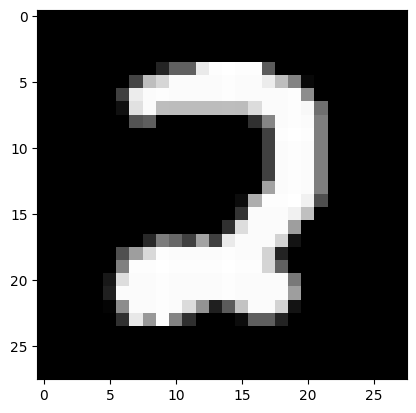

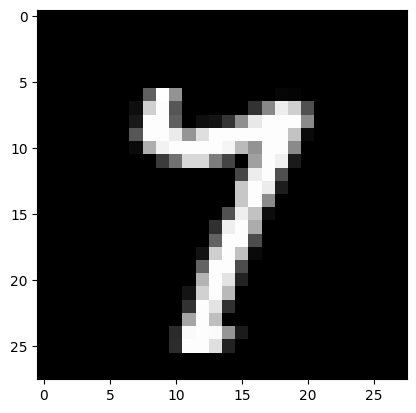

<Figure size 640x480 with 0 Axes>

In [26]:
plt.imshow(training_dataset[5][0].view(28,28), cmap='gray')
plt.figure()
plt.imshow(training_dataset[1][0].view(28,28), cmap='gray')
plt.figure()

In [6]:
testing_dataset = torchvision.datasets.MNIST('/data.', train=False, transform = torchvision.transforms.v2.ToImage(), download=True)

In [7]:
len(testing_dataset)

10000

In [8]:
testing_dataset[0]

(Image([[[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
            0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
         [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
            0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
         [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
            0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
         [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
            0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
         [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
            0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
         [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
            0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
         [  0,   0,   0,   0,   0,

## Creating Validation set from Training Set
Want to ensure that validation is inclusive of the entire dataset

In [9]:
split = torch.utils.data.random_split(training_dataset, [50000,10000], generator= torch.Generator().manual_seed(42))

In [10]:
training_dataset = split[0]
len(training_dataset)

50000

In [11]:
validation_dataset = split[1]
len(validation_dataset)

10000

In [12]:
# Count the number of each value in the validation dataset
validation_labels = [tup[1] for tup in validation_dataset]

In [13]:
# Counts for each digit in validation set
{(val, validation_labels.count(int(val))) for val in set(validation_labels)}

{(0, 1000),
 (1, 1129),
 (2, 1000),
 (3, 1038),
 (4, 979),
 (5, 875),
 (6, 985),
 (7, 1061),
 (8, 969),
 (9, 964)}

Write about trying to figure out how to initialize Learner class

## Create DataLoaders

In [14]:
class BasicMNISTLearner:
    def __init__(self,train_dl,val_dl,torch_model, loss_fn, epochs, learning_rate,test_dl=None, eval_test=False):
        self.training_dls = train_dl
        self.validation_dls = val_dl
        self.test_dls = test_dl
        self.torch_model = torch_model
        self.loss_fn = loss_fn
        self.epochs = epochs
        self.lr = learning_rate
        self.loss_per_epoch = []
        self.opt = self.SGD_optimizer(self.torch_model.parameters(), self.lr)
        self.eval_test = eval_test

    # Initialize Stochastic Gradient Descent Optimizer Class
    class SGD_optimizer:
        def __init__(self, model_parameters, learning_rate):
            self.model_parameters = model_parameters
            self.lr = learning_rate
        def _zero_grad(self):
            for param in self.model_parameters: param.grad = None
        def step_parameters(self):
            with torch.no_grad():
                for param in self.model_parameters:
                    param -= self.lr * param.grad
                self._zero_grad()
    
    # Train Model
    def fit(self):
        for _ in range(epochs):
            running_loss = 0
            for xbatch, ybatch in self.training_dls:
                xbatch = xbatch.float().view(-1,784)
                ybatch = ybatch.view(-1)
                for param in self.torch_model.parameters(): param.grad = None
                # Forward Pass
                predictions = self.torch_model(xbatch)
                loss = self.loss_fn(predictions, ybatch)
                # Backward Pass
                loss.backward()
                # Optimization Step (In this case only using SGD)
                opt = self.SGD_optimizer(self.torch_model.parameters(), self.lr)
                opt.step_parameters()
                running_loss += loss.item()
            self.loss_per_epoch.append(running_loss/len(self.training_dls))
            # Print Validation Metric at each Epoch
            self.validation_metric(self.validation_dls, False)
        # Plot Loss Curve after Training Loop
        self.plot_training_loss()
        # Test Model on Test Data
        if self.test_dls != None and self.eval_test:
            self.validation_metric(self.test_dls, True)

    # Calculate and Show Accuracy Metric 
    def validation_metric(self, eval_dl,is_test):
        self.torch_model.eval()
        with torch.no_grad():
            correct = 0
            num_samples = 0
            for xvalbatch, yvalbatch in eval_dl:
                xvalbatch = xvalbatch.float().view(-1,784)
                yvalbatch = yvalbatch.view(-1,1).float()
                logits = self.torch_model(xvalbatch)
                # Find batch accuracy
                _, predictions = torch.max(logits, 1)
                # Increment correct
                correct += torch.sum(torch.eq(predictions, yvalbatch.view(-1)))
                num_samples += yvalbatch.shape[0]        
            val_accuracy = correct / num_samples
            if is_test:
                print(f'Test Accuracy: {val_accuracy}, {num_samples}, Correct Images {correct}')
                ConfusionMatrixDisplay.from_predictions(yvalbatch, predictions)
                plt.show()
            else:   
                print(f'Validation Accuracy: {val_accuracy}, {num_samples}, Correct Images {correct}')

    # Plot the training loss 
    def plot_training_loss(self):
        epoch = range(len(self.loss_per_epoch))
        loss = self.loss_per_epoch
        fix, ax = plt.subplots()
        ax.plot(epoch,loss)
        ax.set(xlabel='Epoch_Number', ylabel='Training_Loss', title='Training Loss Curve')
        ax.grid()
        plt.xticks(np.arange(0,self.epochs , step=1))
        plt.show()


    #def build_confusion_mat(self, y_true,)

In [15]:
training_dls = torch.utils.data.DataLoader(training_dataset, batch_size = 256, generator= torch.Generator().manual_seed(42))
validation_dls = torch.utils.data.DataLoader(validation_dataset, batch_size = 256, generator= torch.Generator().manual_seed(42))
testing_dls = torch.utils.data.DataLoader(testing_dataset, batch_size = 10000, generator= torch.Generator().manual_seed(42))

In [16]:
model = nn.Sequential(nn.Linear(28*28, 300),
                     nn.ReLU(),nn.ReLU(),
                     nn.Linear(300, 10))

In [17]:
loss_function = nn.CrossEntropyLoss()
epochs = 10
learning_rate = 0.01

Validation Accuracy: 0.8774999976158142, 10000, Correct Images 8775
Validation Accuracy: 0.9054999947547913, 10000, Correct Images 9055
Validation Accuracy: 0.9241999983787537, 10000, Correct Images 9242
Validation Accuracy: 0.9314000010490417, 10000, Correct Images 9314
Validation Accuracy: 0.9404000043869019, 10000, Correct Images 9404
Validation Accuracy: 0.942799985408783, 10000, Correct Images 9428
Validation Accuracy: 0.939300000667572, 10000, Correct Images 9393
Validation Accuracy: 0.9472000002861023, 10000, Correct Images 9472
Validation Accuracy: 0.9456999897956848, 10000, Correct Images 9457
Validation Accuracy: 0.9480999708175659, 10000, Correct Images 9481


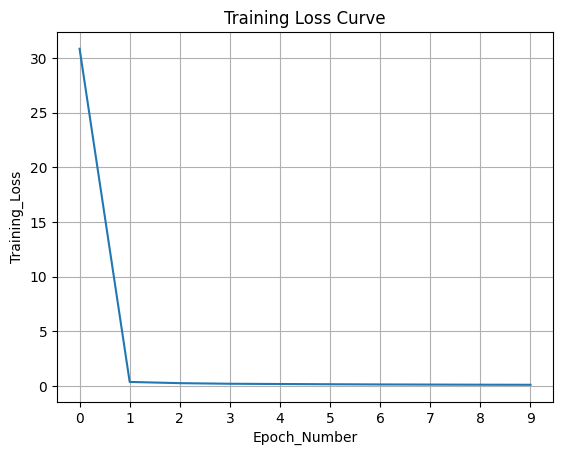

Test Accuracy: 0.9578999876976013, 10000, Correct Images 9579


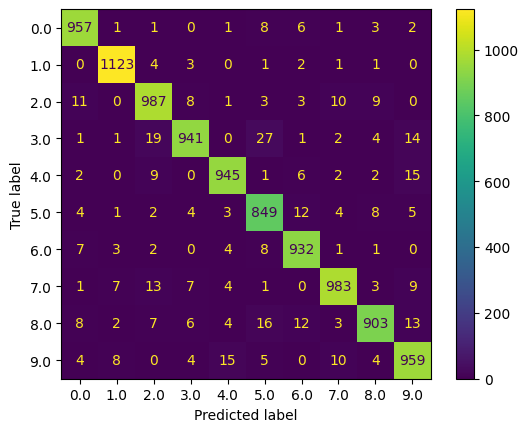

In [18]:
# (self,train_dl,val_dl,torch_model, loss_fn, epochs, learning_rate)
Learner = BasicMNISTLearner(training_dls,validation_dls, model,loss_function,epochs, learning_rate, testing_dls, eval_test=True)
Learner.fit()